In [ ]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install numpy
!pip install plotly

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
import plotly.express
import plotly.express as px
import nbformat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specifico il percorso del file CSV
file_path = r'/content/drive/MyDrive/ESTRAZIONE_MAX_FILTER_TRANSFORMED.csv'

# Carico il file CSV in un DataFrame
df = pd.read_csv(file_path)

In [ ]:
df.sample(5)

,partner_crm,age,NATIO,XSEXU,CRDAT,country_cli,calendar_day,doc_number,mark_down,afs_channel,...,country,sales_qty,SEASON_ID,LEV1B_DESC,LEV2A_DESC,LEV3_DESC,LINE_RECLASS_3_DESC,speso,codice_prodotto,codice_store
1395940,2430924,Z004,IT,M,2019-02-17,IT,2020-10-21,79,FP,WS,...,NaN,1.0,57,FASHION JEWELRY,FASHION JEWELRY,EARRINGS,WOMAN,149.449989,80547384649951,400000223
2059518,2987248,Z004,NaN,U,2020-07-29,US,2020-09-30,80888,MD,FG,...,US,1.0,NaN,NaN,NaN,NaN,NaN,179.987255,80533418292451,400002333
1304253,2365363,Z003,CN,F,2018-12-16,CN,2019-05-23,20111,MD,DG,...,CN,1.0,54,SHOES,SHOES,PUMP,WOMAN,530.513457,80533415415051,400004943
2266916,3193797,Z003,SA,F,2021-01-25,SA,2021-07-07,3105,MD,DG,...,AE,-1.0,NaN,NaN,NaN,NaN,NaN,-104.553950,80524668313171,400009403
333332,1180962,Z004,NaN,F,2014-12-12,JP,2021-08-01,17731,FP,DG,...,JP,1.0,NaN,NaN,NaN,NaN,NaN,649.858521,80524669031371,400001353


In [ ]:
#Drop di colonne escluse dallo sviluppo del modello e impostazione condizioni di filtro
cols_to_drop = ["LEV2A_DESC", "LEV3_DESC", "country", "location_city", "NATIO", "SEASON_ID", "LINE_RECLASS_3_DESC", "codice_store"]
df.drop(columns=cols_to_drop, inplace=True)
df = df[df['sales_qty'] > 0]
df = df[df['afs_channel'] != "VG"]
df = df[df["country_cli"].isna() == False]
df.sample(5)

,partner_crm,age,XSEXU,CRDAT,country_cli,calendar_day,doc_number,mark_down,afs_channel,sales_qty,LEV1B_DESC,speso,codice_prodotto
412154,1333135,Z003,U,2015-07-05,CN,2018-06-22,5523,FP,DG,1.0,SHOES,665.887001,80543046014721
798426,1981098,Z006,F,2017-09-29,AT,2020-10-14,28356,FP,DG,1.0,NaN,120.913227,36142730738991
1221200,2308557,Z004,U,2018-10-05,CN,2018-10-05,49194,FP,DG,1.0,SHOES,553.767099,80543046373891
57017,79247,Z006,F,2010-09-20,CN,2019-07-23,59836,FP,DG,1.0,APPAREL,4674.692141,80523276033361
1556008,2548007,Z002,U,2019-05-29,US,2019-05-28,70034,FP,FG,1.0,SHOES,467.013359,80543043262901


In [ ]:
#Label encoding
label_encoder = LabelEncoder()
df['country_cli'] = label_encoder.fit_transform(df['country_cli'])
df.sample(5)

,partner_crm,age,XSEXU,CRDAT,country_cli,calendar_day,doc_number,mark_down,afs_channel,sales_qty,LEV1B_DESC,speso,codice_prodotto
2379320,3304158,Z004,U,2021-05-11,48,2021-05-11,51890,FP,DG,1.0,SHOES,712.493710,80524666691321
22380,32909,Z004,F,2010-09-20,43,2019-04-08,153882,FP,DG,1.0,SHOES,260.250391,80523275228661
2652697,3642723,Z003,U,2021-12-24,234,2021-12-24,73998,FP,DG,1.0,BELTS,520.794244,80524664565101
809634,1997172,Z005,F,2017-10-21,112,2020-09-23,14526,FP,DG,1.0,LICENCES,171.201756,80565971691411
2344615,3270093,Z003,F,2021-04-12,124,2021-04-12,21281,FP,DG,1.0,LICENCES,76.785253,84110618515311


In [ ]:
discount_mapping = {"FP": 0, "MD": 1}
# Mappa la colonna 'markdown'(sconto) in base al dizionario di mapping
df['mark_down'] = df['mark_down'].map(discount_mapping)

In [ ]:
#Creazione dizionario utilizzato successivamente relativamente al canale d'acquisto
channel_of_sales_mapping = {"DG":0, "FG":1, "WS":2}

In [ ]:
#Mappatura età
age_map = {'Z001': 1, 'Z002': 2, 'Z003': 3, 'Z004': 4, 'Z006': 6, 'Z007': 7}
df['age'] = df['age'].map(age_map, na_action="ignore")
mask_nans = df['age'].isna()
df.loc[mask_nans, "age"] = -1

In [ ]:
unique_clients = df['partner_crm'].unique()
unique_clients

array([         7,         10,         15, ..., 1000101805, 1000101919,
       1000128989])

In [ ]:
# drop delle righe nella mask
df.dropna(subset=['afs_channel'], inplace=True)

In [ ]:

df_buyers = df.groupby(['partner_crm', 'afs_channel']).size().unstack(fill_value=0)
df_buyers

afs_channel,DG,FG,WS
partner_crm,,,
7,1,0,0
10,1,0,0
15,15,0,0
94,5,0,0
104,2,0,0
...,...,...,...
1000101407,0,0,1
1000101700,0,0,1
1000101805,0,0,1


In [ ]:
#Sviluppo filtri per identificare una prima categorizzazione dei client secondo il channel d'acquisto
filter_only_pysical_channel = np.bitwise_and(df_buyers["DG"] + df_buyers["FG"] > 0, df_buyers["WS"] <= 0)
filter_only_digital_channel = np.bitwise_and(df_buyers["DG"] + df_buyers["FG"] <= 0, df_buyers["WS"] > 0)
filter_omnichannel = np.bitwise_and(df_buyers["DG"] + df_buyers["FG"] > 0, df_buyers["WS"] > 0)

#Mappatura
type_mapping = {0: "Physical", 1: "Digital", 2: "Omnichannel"}

for mask, type in zip([filter_only_pysical_channel, filter_only_digital_channel, filter_omnichannel], [0, 1, 2]):
    df_buyers.loc[mask, "type"] = type


In [ ]:
#Impostazione metriche per analisi
avg_spent_by_client = df.groupby(["partner_crm"]).agg({"doc_number": "count", "speso": "mean"})
avg_spent_by_client.rename(columns={"doc_number": "num_transactions", "speso": "avg_spent"}, inplace=True)

In [ ]:
#Riunire i risultati in un'unica tabella
df_buyers = pd.merge(df_buyers, avg_spent_by_client, left_index=True, right_index=True)

In [ ]:
#Mappando numericamente la variabile categorica del sesso del cliente
mapping_sex = {"M": 0, "F": 1, "U": 2}
df.loc[:, "XSEXU"] = df["XSEXU"].map(mapping_sex)

In [ ]:
#Grouppare per ciascun cliente le informazioni demografiche
groupings_demografics = df.groupby(["partner_crm"]).agg({"XSEXU": "first", "age": "first"})

In [ ]:
df_buyers = pd.merge(df_buyers, groupings_demografics, left_index=True, right_index=True)

In [ ]:
#Prendiamo solo il primo country registrato da ciascun cliente
nationality = df.groupby(["partner_crm"]).agg({"country_cli": "first"})

In [ ]:
df_buyers = pd.merge(df_buyers, nationality, left_index=True, right_index=True)

In [ ]:
df_buyers.sample(5)

,DG,FG,WS,type,num_transactions,avg_spent,XSEXU,age,country_cli
partner_crm,,,,,,,,,
2174499,1,0,0,0.0,1,815.928052,1,3.0,125
2757324,1,0,0,0.0,1,549.198751,2,3.0,76
2258226,1,0,0,0.0,1,612.838944,0,2.0,124
3404272,1,0,0,0.0,1,408.766644,1,4.0,125
2218020,1,0,0,0.0,1,472.411083,2,3.0,79


In [ ]:
test_df = df_buyers.drop(columns=["country_cli", "type"])

# transformer = StandardScaler()
# cols = ["avg_spent", "DG", "FG", "WS", "num_transactions"]
# test_df.loc[:, cols] = transformer.fit_transform(test_df[cols].values)

from sklearn.preprocessing import MaxAbsScaler
max_transformer = MaxAbsScaler()
cols = ["age", "XSEXU"] + ["avg_spent", "DG", "FG", "WS", "num_transactions"]
test_df.loc[:, cols] = max_transformer.fit_transform(test_df[cols].values)

test_df.sample(5)

,DG,FG,WS,num_transactions,avg_spent,XSEXU,age
partner_crm,,,,,,,
3570430,0.000321,0.000000,0.0,0.000321,0.013249,0.5,0.333333
2559489,0.000321,0.021617,0.0,0.007702,0.010186,1.0,0.500000
2974616,0.000321,0.000000,0.0,0.000321,0.023656,0.5,0.500000
507703,0.001605,0.000000,0.0,0.001605,0.014017,1.0,0.666667
3355129,0.000321,0.000000,0.0,0.000321,0.005362,0.5,0.500000


In [ ]:
# computando e salvando multipli modelli di knn con diversi numeri di cluster
from sklearn.cluster import KMeans
n_of_clusters = [x for x in range(2, 16)]
knn_models = []

for n in n_of_clusters:
    knn = KMeans(n_clusters=n, random_state=42, max_iter=1000)
    knn.fit(test_df)
    knn_models.append(knn)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
# Calcolando l'elbow method
inertias = [knn.inertia_ for knn in knn_models]
plot = plotly.express.line(x=n_of_clusters, y=inertias)
plot.show()

In [ ]:
import time
# Calcolando il silhouette score
silhouettes = []

for idx, m in enumerate(knn_models[5:10]):
    print("Computing silhouette score")
    test_df_sample = test_df.copy()
    test_df_sample["label"] = m.labels_
    final_df_sample = test_df_sample.sample(frac=0.25, random_state=42)
    df_sample_labels = final_df_sample["label"]
    final_df_sample.drop(columns=["label"], inplace=True)
    t0 = time.time()
    s = silhouette_score(final_df_sample, df_sample_labels)
    t1 = time.time()
    silhouettes.append(s)
    print(f"Silhouette score: {s} computed in {t1-t0} seconds for KNN model {idx}")

Computing silhouette score
Silhouette score: 0.6814009662413294 computed in 868.1258354187012 seconds for KNN model 0
Computing silhouette score
Silhouette score: 0.750426732289303 computed in 863.04221534729 seconds for KNN model 1
Computing silhouette score
Silhouette score: 0.7660008677801458 computed in 823.9878978729248 seconds for KNN model 2
Computing silhouette score
Silhouette score: 0.8269345713700619 computed in 801.2397820949554 seconds for KNN model 3
Computing silhouette score
Silhouette score: 0.8337650787952103 computed in 841.6516191959381 seconds for KNN model 4


In [ ]:
plot_siluette = plotly.express.line(x=range(5,10), y=silhouettes)
plot_siluette.show()

In [ ]:
knn_at_10 = KMeans(n_clusters=10, random_state=42, max_iter=1000).fit(test_df)
knn_at_15 = KMeans(n_clusters=15, random_state=42, max_iter=1000).fit(test_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
#Calcolando il silhoutte score per 10-15 cluster
silhouettes_10_15 = []

for idx, m in enumerate([knn_at_10, knn_at_15]):
    print("Computing silhouette score")
    test_df_sample = test_df.copy()
    test_df_sample["label"] = m.labels_
    final_df_sample = test_df_sample.sample(frac=0.25, random_state=42)
    df_sample_labels = final_df_sample["label"]
    final_df_sample.drop(columns=["label"], inplace=True)
    t0 = time.time()
    s = silhouette_score(final_df_sample, df_sample_labels)
    t1 = time.time()
    silhouettes_10_15.append(s)
    print(f"Silhouette score: {s} computed in {t1-t0} seconds for KNN model {idx}")

Computing silhouette score
Silhouette score: 0.8269345713700619 computed in 876.2824022769928 seconds for KNN model 0
Computing silhouette score
Silhouette score: 0.9164021387283339 computed in 874.0745408535004 seconds for KNN model 1


In [ ]:
knn_at_18 = KMeans(n_clusters=18, random_state=42, max_iter=1000).fit(test_df)

#0.94 evaluation of 18 cluster

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Calcolando il silhoutte score per 18 cluster
from sklearn.metrics import silhouette_score


knn_at_18 = KMeans(n_clusters=18, random_state=42, max_iter=1000).fit(test_df)

silhouettes_18 = []

print("Computing silhouette score")
test_df_sample = test_df.copy()
test_df_sample["label"] = knn_at_18.labels_
final_df_sample = test_df_sample.sample(frac=0.25, random_state=42)
df_sample_labels = final_df_sample["label"]
final_df_sample.drop(columns=["label"], inplace=True)
t0 = time.time()
s = silhouette_score(final_df_sample, df_sample_labels)
t1 = time.time()
silhouettes_18.append(s)
print(f"Silhouette score: {s} computed in {t1-t0} seconds for KNN model 18")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Computing silhouette score
Silhouette score: 0.9437913739424604 computed in 719.2477474212646 seconds for KNN model 18


In [ ]:
# Dati dei silhouette score per diversi K
data = {
    'K': [5, 6, 7, 8, 9, 10, 15, 18],
    'Silhouette Score': [0.681, 0.750, 0.766, 0.827, 0.834, 0.833, 0.916, 0.944]
}

# Creazione del dataframe
df = pd.DataFrame(data)

# Creazione del grafico
fig = px.line(df, x='K', y='Silhouette Score', markers=True, title='Silhouette Score vs Number of Clusters')

# Personalizzazione del grafico
fig.update_layout(xaxis_title='Number of Clusters (K)', yaxis_title='Silhouette Score')

# Visualizzazione del grafico
fig.show()

In [ ]:
test_df_sample.sample(5)

,DG,FG,WS,num_transactions,avg_spent,XSEXU,age,label
partner_crm,,,,,,,,
1411867,0.000321,0.0,0.000000,0.000321,0.037227,1.0,0.333333,7
2875736,0.000321,0.0,0.000000,0.000321,0.007944,0.0,0.333333,12
2123496,0.000321,0.0,0.000000,0.000321,0.012597,1.0,0.333333,7
2988676,0.000000,0.0,0.004808,0.000321,0.005098,0.5,0.666667,5
2805922,0.000321,0.0,0.000000,0.000321,0.036427,0.5,0.500000,1


from matplotlib import pyplot as plt
_df_0['DG'].plot(kind='hist', bins=20, title='DG')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['WS'].plot(kind='hist', bins=20, title='WS')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['avg_spent'].plot(kind='hist', bins=20, title='avg_spent')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('XSEXU').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='DG', y='WS', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='WS', y='avg_spent', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='avg_spent', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='age', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FG']
  ys = series['DG']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('FG', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('XSEXU')):
  _plot_series(series, series_name, i)
  fig.legend(title='XSEXU', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FG')
_ = plt.ylabel('DG')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FG']
  ys = series['WS']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('FG', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('XSEXU')):
  _plot_series(series, series_name, i)
  fig.legend(title='XSEXU', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FG')
_ = plt.ylabel('WS')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FG']
  ys = series['avg_spent']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('FG', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('XSEXU')):
  _plot_series(series, series_name, i)
  fig.legend(title='XSEXU', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FG')
_ = plt.ylabel('avg_spent')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FG']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('FG', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('XSEXU')):
  _plot_series(series, series_name, i)
  fig.legend(title='XSEXU', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FG')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
_df_13['DG'].plot(kind='line', figsize=(8, 4), title='DG')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['WS'].plot(kind='line', figsize=(8, 4), title='WS')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['avg_spent'].plot(kind='line', figsize=(8, 4), title='avg_spent')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['XSEXU'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='DG', y='XSEXU', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['XSEXU'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='WS', y='XSEXU', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['XSEXU'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='avg_spent', y='XSEXU', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['XSEXU'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='age', y='XSEXU', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Salvataggio del DataFrame come un file CSV
file_path = '/content/test_df_sample.csv'
test_df_sample.to_csv(file_path)

print(f"File salvato: {file_path}")

File salvato: /content/test_df_sample.csv


In [ ]:
# Specificando il percorso del file CSV
file_path_result = r'/content/drive/MyDrive/test_df_sample_knn.csv'

# Caricando il file CSV in un DataFrame
df_result_knn = pd.read_csv(file_path_result)

print(df_result_knn.head)


<bound method NDFrame.head of         partner_crm        DG   FG        WS  num_transactions  avg_spent  \
0                 7  0.000321  0.0  0.000000          0.000321   0.023788   
1                10  0.000321  0.0  0.000000          0.000321   0.004086   
2                15  0.004814  0.0  0.000000          0.004814   0.019247   
3                94  0.001605  0.0  0.000000          0.001605   0.008435   
4               104  0.000642  0.0  0.000000          0.000642   0.007010   
...             ...       ...  ...       ...               ...        ...   
996224   1000101407  0.000000  0.0  0.004808          0.000321   0.013108   
996225   1000101700  0.000000  0.0  0.004808          0.000321   0.002355   
996226   1000101805  0.000000  0.0  0.004808          0.000321   0.009814   
996227   1000101919  0.000000  0.0  0.004808          0.000321   0.006473   
996228   1000128989  0.002888  0.0  0.038462          0.005456   0.014628   

        XSEXU       age  label  
0         1.

   partner_crm        DG   FG   WS  num_transactions  avg_spent  XSEXU  \
0            7  0.000321  0.0  0.0          0.000321   0.023788    1.0   
1           10  0.000321  0.0  0.0          0.000321   0.004086    0.5   
2           15  0.004814  0.0  0.0          0.004814   0.019247    0.5   
3           94  0.001605  0.0  0.0          0.001605   0.008435    0.5   
4          104  0.000642  0.0  0.0          0.000642   0.007010    1.0   

        age  label  
0  1.000000     10  
1  0.500000      1  
2  0.666667      5  
3 -0.166667      3  
4  0.666667     11  


<ipython-input-33-85d3474afbfe>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=cluster_data, x='Cluster', y='NumberOfCustomers', palette='viridis')
<ipython-input-33-85d3474afbfe>:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  bar_plot.get_figure().colorbar(sm, label='Total Spent')


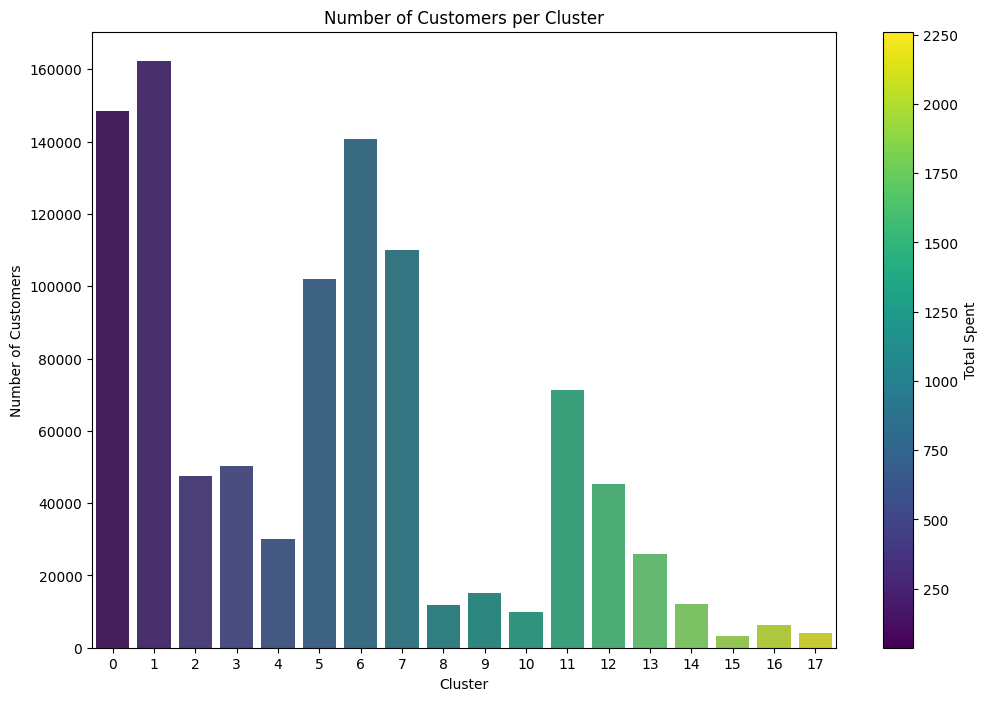

In [ ]:
file_path_result = r'/content/drive/MyDrive/test_df_sample_knn.csv'
df_result_knn = pd.read_csv(file_path_result)

# Verificando le prime righe del DataFrame
print(df_result_knn.head())

# Analisi del numero di clienti per ciascun cluster
cluster_counts = df_result_knn['label'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'NumberOfCustomers']

# Analisi delle metriche per cluster
cluster_metrics = df_result_knn.groupby('label').agg({
    'avg_spent': 'sum'
}).reset_index()
cluster_metrics.columns = ['Cluster', 'TotalSpent']

# Merge per avere i conteggi e i valori medi insieme
cluster_data = pd.merge(cluster_counts, cluster_metrics, on='Cluster')

# Visualizzare la distribuzione dei clienti per cluster con barra colorata per valore monetario medio
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=cluster_data, x='Cluster', y='NumberOfCustomers', palette='viridis')
bar_plot.set_title('Number of Customers per Cluster')
bar_plot.set_xlabel('Cluster')
bar_plot.set_ylabel('Number of Customers')

# Aggiungere la barra colore per il valore monetario medio
norm = plt.Normalize(cluster_data['TotalSpent'].min(), cluster_data['TotalSpent'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
bar_plot.get_figure().colorbar(sm, label='Total Spent')

plt.show()




   partner_crm        DG   FG   WS  num_transactions  avg_spent  XSEXU  \
0            7  0.000321  0.0  0.0          0.000321   0.023788    1.0   
1           10  0.000321  0.0  0.0          0.000321   0.004086    0.5   
2           15  0.004814  0.0  0.0          0.004814   0.019247    0.5   
3           94  0.001605  0.0  0.0          0.001605   0.008435    0.5   
4          104  0.000642  0.0  0.0          0.000642   0.007010    1.0   

        age  label  
0  1.000000     10  
1  0.500000      1  
2  0.666667      5  
3 -0.166667      3  
4  0.666667     11  


<ipython-input-33-e18ed6089785>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_counts, x='Cluster', y='NumberOfCustomers', palette='viridis')


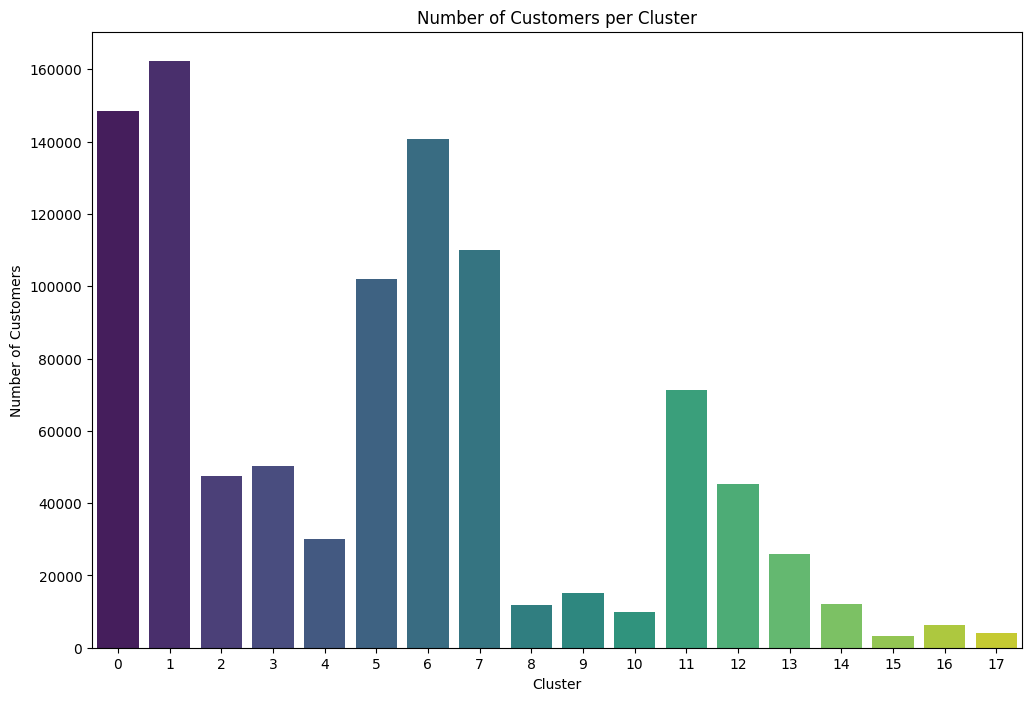

<ipython-input-33-e18ed6089785>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_metrics, x='Cluster', y='AvgNumTransactions', palette='viridis', ax=axs[0])
<ipython-input-33-e18ed6089785>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_metrics, x='Cluster', y='AvgSpent', palette='viridis', ax=axs[1])
<ipython-input-33-e18ed6089785>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_metrics, x='Cluster', y='AvgGender', palette='viridis', ax=axs[2])
<ipython-input-33-e18ed6089785>:53: FutureWarning: 



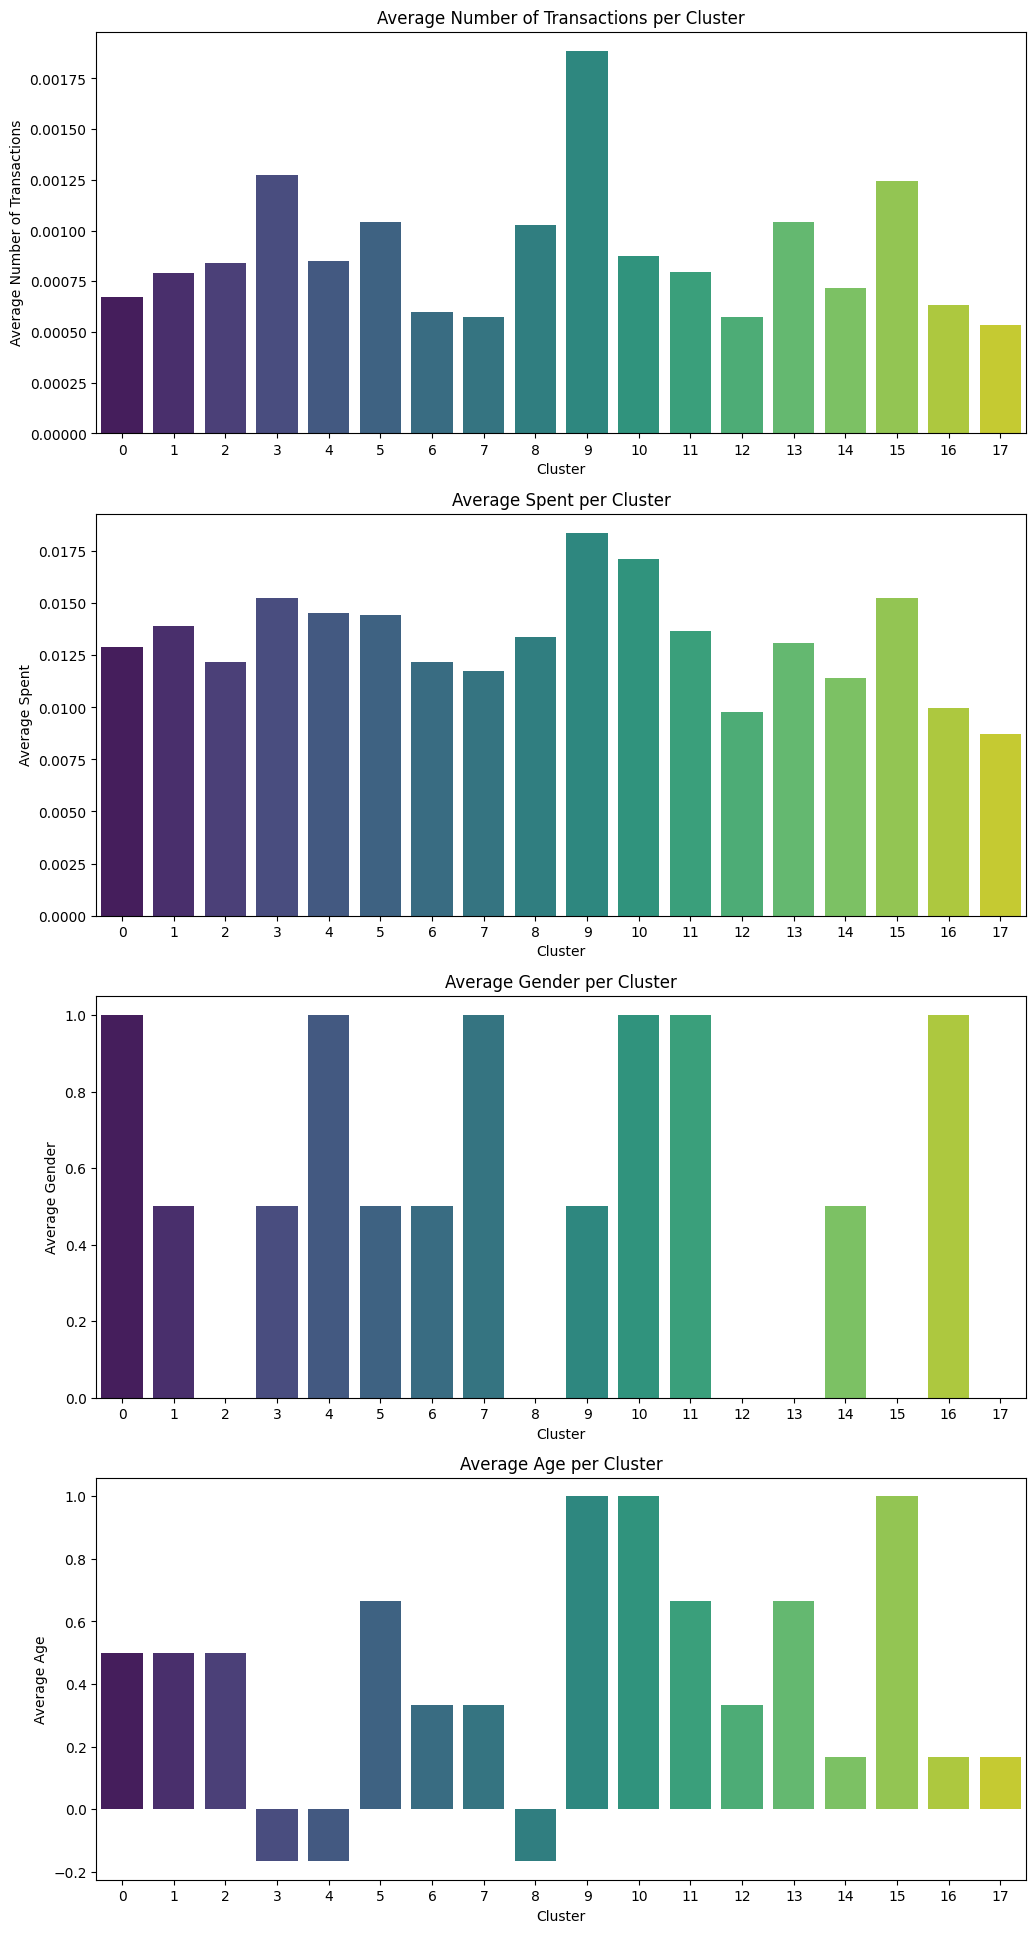

KeyError: 'age'

In [ ]:
file_path_result = '/content/drive/MyDrive/test_df_sample_knn.csv'

df_result_knn = pd.read_csv(file_path_result)


# Analisi del numero di clienti per ciascun cluster
cluster_counts = df_result_knn['label'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'NumberOfCustomers']

# Visualizzare la distribuzione dei clienti per cluster
plt.figure(figsize=(12, 8))
sns.barplot(data=cluster_counts, x='Cluster', y='NumberOfCustomers', palette='viridis')
plt.title('Number of Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Analisi delle metriche per cluster
cluster_metrics = df_result_knn.groupby('label').agg({
    'num_transactions': 'mean',
    'avg_spent': 'mean',
    'XSEXU': 'mean',
    'age': 'mean'
}).reset_index()
cluster_metrics.columns = ['Cluster', 'AvgNumTransactions', 'AvgSpent', 'AvgGender', 'AvgAge']

# Visualizzazione delle metriche per cluster
fig, axs = plt.subplots(4, 1, figsize=(12, 24))
sns.barplot(data=cluster_metrics, x='Cluster', y='AvgNumTransactions', palette='viridis', ax=axs[0])
axs[0].set_title('Average Number of Transactions per Cluster')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Average Number of Transactions')

sns.barplot(data=cluster_metrics, x='Cluster', y='AvgSpent', palette='viridis', ax=axs[1])
axs[1].set_title('Average Spent per Cluster')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Average Spent')

sns.barplot(data=cluster_metrics, x='Cluster', y='AvgGender', palette='viridis', ax=axs[2])
axs[2].set_title('Average Gender per Cluster')
axs[2].set_xlabel('Cluster')
axs[2].set_ylabel('Average Gender')

sns.barplot(data=cluster_metrics, x='Cluster', y='AvgAge', palette='viridis', ax=axs[3])
axs[3].set_title('Average Age per Cluster')
axs[3].set_xlabel('Cluster')
axs[3].set_ylabel('Average Age')

plt.show()

# Analisi demografica per ciascun cluster
df_geo = df[['partner_crm', 'country_cli', 'age', 'XSEXU']].drop_duplicates()
df_customer_geo = pd.merge(df_result_knn, df_geo, on='partner_crm')

# Distribuzione demografica per cluster
for cluster in df_result_knn['label'].unique():
    cluster_data = df_customer_geo[df_customer_geo['label'] == cluster]

    # Distribuzione delle categorie di età
    age_distribution = cluster_data['age'].value_counts(normalize=True).reset_index()
    age_distribution.columns = ['Categoria_Prodotto', 'Proportion']
    print(f"Distribuzione percentuale delle categorie di età per il cluster {cluster}:")
    print(age_distribution)

    # Distribuzione per genere
    gender_distribution = cluster_data['XSEXU'].value_counts(normalize=True).reset_index()
    gender_distribution.columns = ['Genere', 'Proportion']
    print(f"Distribuzione percentuale per genere per il cluster {cluster}:")
    print(gender_distribution)

    # Distribuzione per paese
    country_distribution = cluster_data['country_cli'].value_counts(normalize=True).reset_index()
    country_distribution.columns = ['Paese', 'Proportion']
    print(f"Distribuzione percentuale per paese per il cluster {cluster}:")
    print(country_distribution)

    # Distribuzione delle tipologie di prodotti acquistati (LINE_RECLASS_3_DESC)
    product_distribution = df[df['partner_crm'].isin(cluster_data['partner_crm'])]['LINE_RECLASS_3_DESC'].value_counts(normalize=True).reset_index()
    product_distribution.columns = ['Tipologia_Prodotto', 'Proportion']
    print(f"Distribuzione percentuale delle tipologie di prodotti (LINE_RECLASS_3_DESC) per il cluster {cluster}:")
    print(product_distribution)

    # Distribuzione degli acquisti tra i vari canali (afs_channel)
    channel_distribution = df[df['partner_crm'].isin(cluster_data['partner_crm'])]['afs_channel'].value_counts(normalize=True).reset_index()
    channel_distribution.columns = ['Canale_Acquisto', 'Proportion']
    print(f"Distribuzione percentuale degli acquisti tra i vari canali per il cluster {cluster}:")
    print(channel_distribution)

    print("\n" + "-"*80 + "\n")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


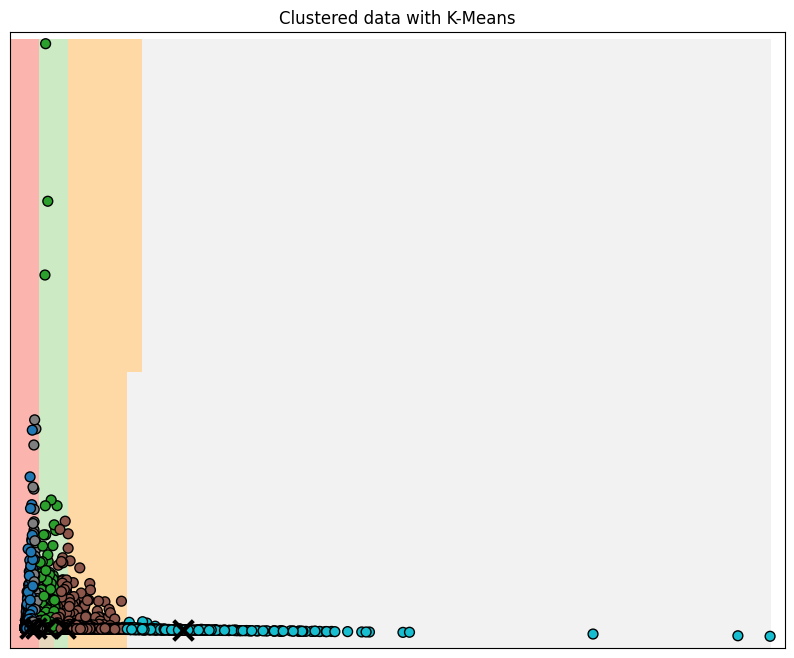

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Supponiamo che X sia il DataFrame con i dati di clustering
X = df_result_knn[['avg_spent', 'num_transactions']]  # Usa le colonne appropriate

# Ridurre la dimensionalità a 2 componenti principali per la visualizzazione
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Creare il modello di clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_pca)

# Etichette e centroidi
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Funzione per tracciare i cluster
def plot_clusters(data, epsilon, model, labels, centroids):
    x_min, x_max = data[:, 0].min() - epsilon, data[:, 0].max() + epsilon
    y_min, y_max = data[:, 1].min() - epsilon, data[:, 1].max() + epsilon
    xx, yy = np.meshgrid(np.arange(x_min, x_max, epsilon),
                         np.arange(y_min, y_max, epsilon))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Pastel1,
               aspect='auto', origin='lower')

    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=plt.cm.tab10, edgecolor='k', s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='black', zorder=10)

    plt.title('Clustered data with K-Means')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

# Parametro epsilon per definire la granularità della griglia
epsilon = 0.02

# Tracciare i cluster
plot_clusters(X_pca, epsilon, kmeans, labels, centroids)

In [ ]:

file_path_original = r'/content/drive/MyDrive/ESTRAZIONE_MAX_FILTER_TRANSFORMED.csv'
file_path_result = r'/content/drive/MyDrive/test_df_sample_knn.csv'

# Caricando il file CSV originale e il risultato KNN in DataFrame
df_original = pd.read_csv(file_path_original)
df_result_knn = pd.read_csv(file_path_result)

# Verifica delle prime righe del DataFrame originale
print(df_original.head())

# Aggregare i dati per cliente e scontrino
df_aggregated = df_original.groupby(['partner_crm', 'doc_number']).agg({
    'calendar_day': 'max',  # Data ultima transazione per scontrino
    'speso': 'sum'          # Totale speso per scontrino
}).reset_index()

# Calcolo del valore medio per cliente
df_customer_avg = df_aggregated.groupby('partner_crm').agg({
    'calendar_day': 'max',  # Data ultima transazione per cliente
    'doc_number': 'count',  # Numero di scontrini per cliente
    'speso': 'mean'         # Valore medio degli acquisti per scontrino
}).reset_index()

# Rinominare le colonne
df_customer_avg.columns = ['partner_crm', 'LastPurchaseDate', 'Frequency', 'Monetary']

# Convertire la colonna 'LastPurchaseDate' in datetime
df_customer_avg['LastPurchaseDate'] = pd.to_datetime(df_customer_avg['LastPurchaseDate'])

# Calcolo della Recency
analysis_date = pd.to_datetime('2022-01-01')
df_customer_avg['Recency'] = (analysis_date - df_customer_avg['LastPurchaseDate']).dt.days

# Aggiunta delle colonne Frequency e Monetary
df_customer_avg = pd.merge(df_customer_avg, df_result_knn[['partner_crm', 'label']], on='partner_crm', how='left')

# Verifica del risultato della merge
print(df_customer_avg.head())

# Unire il DataFrame risultante con il DataFrame originale
df_merged = pd.merge(df_original, df_customer_avg[['partner_crm', 'label']], on='partner_crm', how='left')

# Verifica del DataFrame finale
print(df_merged.head())




   partner_crm   age NATIO XSEXU       CRDAT country_cli calendar_day  \
0            7  Z006   NaN     U  2010-09-19          US   2018-10-03   
1           10  Z003   NaN     F  2010-09-19          LB   2018-07-23   
2           15  Z004   NaN     F  2010-09-19          NG   2018-05-31   
3           15  Z004   NaN     F  2010-09-19          NG   2018-05-31   
4           15  Z004   NaN     F  2010-09-19          NG   2021-02-24   

   doc_number mark_down afs_channel  ... country sales_qty  SEASON_ID  \
0        4460        FP          DG  ...      US       1.0         ZZ   
1        5361        MD          DG  ...      IT       1.0        NaN   
2       41738        MD          DG  ...      GB       1.0         49   
3       41738        MD          DG  ...      GB       1.0         49   
4       50419        FP          DG  ...      GB       1.0         58   

            LEV1B_DESC LEV2A_DESC     LEV3_DESC LINE_RECLASS_3_DESC  \
0                SHOES      SHOES    SHORT BOOT    

In [ ]:
# Calcolare l'età media per cluster
age_mapping = {'Z001': 19, 'Z002': 25, 'Z003': 35, 'Z004': 45, 'Z005': 55, 'Z006': 65}
df_merged['age_num'] = df_merged['age'].map(age_mapping)

age_cluster = df_merged.groupby('label')['age_num'].mean().reset_index()
age_cluster.columns = ['Cluster', 'Average Age']
print("Età media per cluster:")
print(age_cluster)

Età media per cluster:
    Cluster  Average Age
0       0.0         35.0
1       1.0         35.0
2       2.0         35.0
3       3.0         55.0
4       4.0         55.0
5       5.0         45.0
6       6.0         25.0
7       7.0         25.0
8       8.0         55.0
9       9.0         65.0
10     10.0         65.0
11     11.0         45.0
12     12.0         25.0
13     13.0         45.0
14     14.0         19.0
15     15.0         65.0
16     16.0         19.0
17     17.0         19.0


In [ ]:
# Calcolare la distribuzione percentuale del genere per cluster
gender_cluster = df_merged.groupby(['label', 'XSEXU']).size().unstack().fillna(0)
gender_cluster = gender_cluster.div(gender_cluster.sum(axis=1), axis=0) * 100
print("Distribuzione percentuale del genere per cluster:")
print(gender_cluster)

Distribuzione percentuale del genere per cluster:
XSEXU      F      M      U
label                     
0.0      0.0    0.0  100.0
1.0    100.0    0.0    0.0
2.0      0.0  100.0    0.0
3.0    100.0    0.0    0.0
4.0      0.0    0.0  100.0
5.0    100.0    0.0    0.0
6.0    100.0    0.0    0.0
7.0      0.0    0.0  100.0
8.0      0.0  100.0    0.0
9.0    100.0    0.0    0.0
10.0     0.0    0.0  100.0
11.0     0.0    0.0  100.0
12.0     0.0  100.0    0.0
13.0     0.0  100.0    0.0
14.0   100.0    0.0    0.0
15.0     0.0  100.0    0.0
16.0     0.0    0.0  100.0
17.0     0.0  100.0    0.0


In [ ]:
# Calcolare il valore medio del cliente per cluster
monetary_cluster = df_merged.groupby('label')['speso'].mean().reset_index()
monetary_cluster.columns = ['Cluster', 'Average Monetary Value']
print("Valore medio del cliente per cluster:")
print(monetary_cluster)

Valore medio del cliente per cluster:
    Cluster  Average Monetary Value
0       0.0              585.889585
1       1.0              684.607477
2       2.0              582.470104
3       3.0              865.566368
4       4.0              667.492122
5       5.0              758.983313
6       6.0              596.220432
7       7.0              541.489513
8       8.0              623.394591
9       9.0             1107.756634
10     10.0              774.393134
11     11.0              625.880047
12     12.0              480.867551
13     13.0              629.767643
14     14.0              608.594900
15     15.0              751.459192
16     16.0              468.150959
17     17.0              438.292814


In [ ]:
# Calcolare la somma del valore monetario per cluster
monetary_cluster = df_merged.groupby('label')['speso'].sum().reset_index()
monetary_cluster.columns = ['Cluster', 'Total Monetary Value']
print("Valore totale del cliente per cluster:")
print(monetary_cluster)


Valore totale del cliente per cluster:
    Cluster  Total Monetary Value
0       0.0          1.940894e+08
1       1.0          2.956471e+08
2       2.0          7.764909e+07
3       3.0          1.892284e+08
4       4.0          5.696912e+07
5       5.0          2.748241e+08
6       6.0          1.681616e+08
7       7.0          1.121436e+08
8       8.0          2.609093e+07
9       9.0          1.082599e+08
10     10.0          2.243262e+07
11     11.0          1.183852e+08
12     12.0          4.238896e+07
13     13.0          5.782904e+07
14     14.0          1.756892e+07
15     15.0          1.063390e+07
16     16.0          6.273223e+06
17     17.0          3.263967e+06


<ipython-input-46-23b10a2f86d8>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




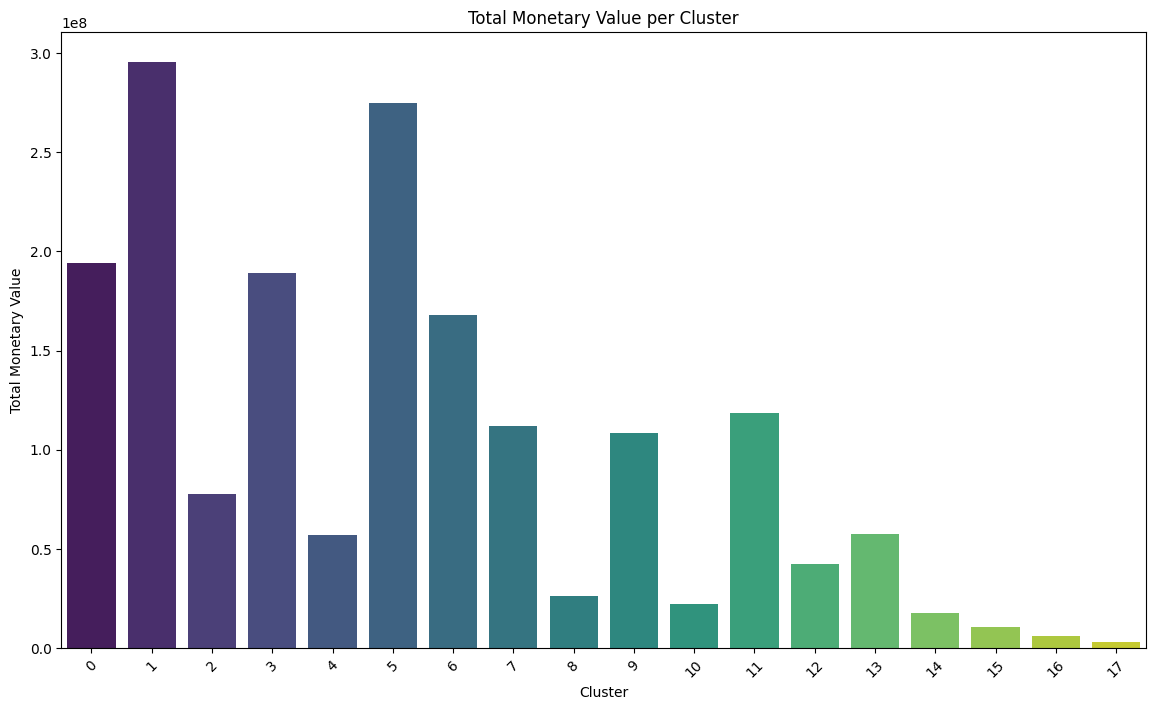

In [ ]:
# Dati dei cluster con valori monetari totali
cluster_data = {
    'Cluster': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
    'Total Monetary Value': [
        1.940894e+08, 2.956471e+08, 7.764909e+07, 1.892284e+08,
        5.696912e+07, 2.748241e+08, 1.681616e+08, 1.121436e+08,
        2.609093e+07, 1.082599e+08, 2.243262e+07, 1.183852e+08,
        4.238896e+07, 5.782904e+07, 1.756892e+07, 1.063390e+07,
        6.273223e+06, 3.263967e+06
    ]
}

# Creare un DataFrame dai dati
df_cluster = pd.DataFrame(cluster_data)

# Creare il grafico a barre
plt.figure(figsize=(14, 8))
sns.barplot(data=df_cluster, x='Cluster', y='Total Monetary Value', palette='viridis')
plt.title('Total Monetary Value per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Monetary Value')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calcolare la distribuzione percentuale dei canali di acquisto per cluster
channel_cluster = df_merged.groupby(['label', 'afs_channel']).size().unstack().fillna(0)
channel_cluster = channel_cluster.div(channel_cluster.sum(axis=1), axis=0) * 100
print("Distribuzione percentuale dei canali di acquisto per cluster:")
print(channel_cluster)

Distribuzione percentuale dei canali di acquisto per cluster:
afs_channel         DG         FG        VG         WS
label                                                 
0.0          84.318976  14.268594  0.063996   1.348435
1.0          83.089150   9.398699  0.124350   7.387802
2.0          81.848051  10.835809  0.080265   7.235875
3.0          84.423058   8.072986  0.068613   7.435344
4.0          81.309462  14.758401  0.091391   3.840746
5.0          82.358773   9.248402  0.086441   8.306384
6.0          83.996582   8.064642  0.064528   7.874247
7.0          87.662118  11.500613  0.033317   0.803952
8.0          75.867919  10.450864  0.293886  13.387332
9.0          89.515906   6.765648  0.054232   3.664214
10.0         85.836095  12.386081  0.027617   1.750207
11.0         82.093048  15.872059  0.045995   1.988898
12.0         77.231115   9.690191  0.038570  13.040124
13.0         81.260210   9.578986  0.133949   9.026855
14.0         90.016627   5.625606  0.000000   4.357766
15.

In [ ]:
# Calcolare la distribuzione percentuale delle categorie di prodotti per cluster
product_cluster = df_merged.groupby(['label', 'LINE_RECLASS_3_DESC']).size().unstack().fillna(0)
product_cluster = product_cluster.div(product_cluster.sum(axis=1), axis=0) * 100
print("Distribuzione percentuale delle categorie di prodotti per cluster:")
print(product_cluster)

Distribuzione percentuale delle categorie di prodotti per cluster:
LINE_RECLASS_3_DESC  LICENSES        MAN      WOMAN
label                                              
0.0                  3.600674  23.025973  73.373352
1.0                  2.891390  12.721025  84.387584
2.0                  2.720612  59.498669  37.780719
3.0                  3.125995   6.986078  89.887927
4.0                  3.473443  16.747607  79.778950
5.0                  3.018799   9.559680  87.421520
6.0                  2.902635  13.865477  83.231888
7.0                  4.570973  23.981543  71.447484
8.0                  3.884040  46.272005  49.843956
9.0                  2.874917   4.650027  92.475056
10.0                 4.172156  12.975606  82.852238
11.0                 3.521535  21.055844  75.422621
12.0                 3.215146  62.851406  33.933448
13.0                 2.732685  53.474111  43.793203
14.0                 3.558623   9.176081  87.265297
15.0                 3.107221  43.428155  53.4646

In [ ]:
# Calcolare il numero di scontrini distinti per ciascun cliente
df_frequency = df_merged.groupby('partner_crm')['doc_number'].nunique().reset_index()
df_frequency.columns = ['partner_crm', 'Frequency']

# Unire la frequenza con il DataFrame originale
df_merged = pd.merge(df_merged, df_frequency, on='partner_crm', how='left')

# Calcolare la frequenza media per cluster
frequency_cluster = df_merged.groupby('label')['Frequency'].mean().reset_index()
frequency_cluster.columns = ['Cluster', 'Average Frequency']
print("Frequenza media per cluster:")
print(frequency_cluster)

Frequenza media per cluster:
    Cluster  Average Frequency
0       0.0          41.947056
1       1.0          10.972870
2       2.0          12.666769
3       3.0          17.637733
4       4.0           7.552245
5       5.0          16.873892
6       6.0           6.076087
7       7.0           3.336467
8       8.0          14.035625
9       9.0          29.011552
10     10.0           6.383492
11     11.0           7.284758
12     12.0           5.479064
13     13.0          67.614565
14     14.0           9.108494
15     15.0          18.593103
16     16.0         121.676119
17     17.0           3.022157


In [ ]:
# Calcolare la data dell'ultimo acquisto per ogni cliente
df['calendar_day'] = pd.to_datetime(df['calendar_day'])
last_purchase_date = df.groupby('partner_crm')['calendar_day'].max().reset_index()
last_purchase_date.columns = ['partner_crm', 'LastPurchaseDate']

# Unire con il DataFrame dei cluster
df_cluster = pd.merge(df_result_knn, last_purchase_date, on='partner_crm', how='left')

# Calcolare la Recency (giorni dall'ultimo acquisto)
reference_date = pd.to_datetime('2022-01-01')
df_cluster['Recency'] = (reference_date - df_cluster['LastPurchaseDate']).dt.days

# Calcolare la Recency media per cluster
recency_cluster = df_cluster.groupby('label')['Recency'].mean().reset_index()
recency_cluster.columns = ['Cluster', 'Average Recency']
print("Recency media per cluster:")
print(recency_cluster)

Recency media per cluster:
    Cluster  Average Recency
0         0       714.136589
1         1       590.180024
2         2       599.580881
3         3       496.060529
4         4       741.620551
5         5       527.764312
6         6       638.730845
7         7       729.627636
8         8       537.860126
9         9       479.326989
10       10       785.111469
11       11       726.519333
12       12       607.851224
13       13       556.642433
14       14       699.720237
15       15       535.498953
16       16       757.477932
17       17       743.119506


In [ ]:
#CHECK DELLE COLONNE DF

# Verificare i nomi delle colonne nel DataFrame
print(df_cluster.columns)

# Assicurarsi che la colonna 'country_cli' esista nel DataFrame
if 'country_cli' in df_cluster.columns:
    # Mappare la distribuzione geografica dei cluster
    geo_distribution = df_cluster.groupby(['label', 'country_cli']).size().unstack().fillna(0)
    geo_distribution = geo_distribution.div(geo_distribution.sum(axis=1), axis=0) * 100
    print("Distribuzione geografica per cluster:")
    print(geo_distribution)
else:
    print("La colonna 'country_cli' non esiste nel DataFrame.")

Index(['partner_crm', 'DG', 'FG', 'WS', 'num_transactions', 'avg_spent',
       'XSEXU', 'age', 'label', 'LastPurchaseDate', 'Recency'],
      dtype='object')
La colonna 'country_cli' non esiste nel DataFrame.


In [ ]:

file_path = r'/content/drive/MyDrive/ESTRAZIONE_MAX_FILTER_TRANSFORMED.csv'
df = pd.read_csv(file_path)

#Numero di record e di variabili
num_records = df.shape[0]
num_variables = df.shape[1]

print(f"Il dataset è composto da {num_records} record e {num_variables} variabili.")

Il dataset è composto da 2673343 record e 21 variabili.


In [ ]:
print(df_customer_geo.columns)
print(top_countries_per_cluster.columns)

Index(['partner_crm', 'DG', 'FG', 'WS', 'num_transactions', 'avg_spent',
       'XSEXU_x', 'age_x', 'label', 'speso', 'country_cli', 'age_y',
       'XSEXU_y'],
      dtype='object')
Index(['label', 'country_cli', 'CustomerCount'], dtype='object')


In [ ]:
#Prime righe del DataFrame per confermare la presenza della colonna
print(df_customer_geo.head())

# Controllando se la colonna 'country_cli' è presente
print('country_cli' in df_customer_geo.columns)


   partner_crm        DG   FG   WS  num_transactions  avg_spent  XSEXU_x  \
0            7  0.000321  0.0  0.0          0.000321   0.023788      1.0   
1           10  0.000321  0.0  0.0          0.000321   0.004086      0.5   
2           15  0.004814  0.0  0.0          0.004814   0.019247      0.5   
3           15  0.004814  0.0  0.0          0.004814   0.019247      0.5   
4           15  0.004814  0.0  0.0          0.004814   0.019247      0.5   

      age_x  label        speso  country_cli  age_y XSEXU_y  
0  1.000000     10  1236.810677          234    6.0       2  
1  0.500000      1   212.427209          129    3.0       1  
2  0.666667      5   378.292620          165    4.0       1  
3  0.666667      5   321.523596          165    4.0       1  
4  0.666667      5  2302.348958          165    4.0       1  
True


In [ ]:
file_path = r'/content/drive/MyDrive/ESTRAZIONE_MAX_FILTER_TRANSFORMED.csv'
df_original = pd.read_csv(file_path)

print("Colonne di df_original:", df_original.columns)

# Eseguire la merge tra il DataFrame derivato dal clustering e il DataFrame originale
df_merged = pd.merge(df_result_knn, df_original, on='partner_crm', how='left')

# Verifica delle colonne nel DataFrame unito
print("Colonne di df_merged:", df_merged.columns)

# Funzione per ottenere i top 5 prodotti per ciascun cluster
def get_top_products(df, product_col):
    # Raggruppa i dati per cluster e tipo di prodotto, e calcola il numero di acquisti per ogni combinazione
    product_counts = df.groupby(['label', product_col]).size().reset_index(name='PurchaseCount')

    # Ordinare i risultati per cluster e conteggio degli acquisti
    product_counts_sorted = product_counts.sort_values(by=['label', 'PurchaseCount'], ascending=[True, False])

    # Ottienere i top 5 tipi di prodotto per ciascun cluster
    top_products_per_cluster = product_counts_sorted.groupby('label').head(5)

    # Visualizzare i risultati senza indici derivante dal df originale
    for cluster in top_products_per_cluster['label'].unique():
        print(f"Cluster {cluster}:")
        cluster_data = top_products_per_cluster[top_products_per_cluster['label'] == cluster]
        print(cluster_data[[product_col, 'PurchaseCount']].to_string(index=False))
        print("\n")

# Tentativo con LEV1B_DESC
if 'LEV1B_DESC' in df_merged.columns:
    print("Top 5 prodotti per cluster (LEV1B_DESC):")
    get_top_products(df_merged, 'LEV1B_DESC')
else:
    print("Colonna 'LEV1B_DESC' non trovata nel DataFrame unito.")

# Tentativo con LEV2A_DESC
if 'LEV2A_DESC' in df_merged.columns:
    print("Top 5 prodotti per cluster (LEV2A_DESC):")
    get_top_products(df_merged, 'LEV2A_DESC')
else:
    print("Colonna 'LEV2A_DESC' non trovata nel DataFrame unito.")

# Tentativo con LEV3_DESC
if 'LEV3_DESC' in df_merged.columns:
    print("Top 5 prodotti per cluster (LEV3_DESC):")
    get_top_products(df_merged, 'LEV3_DESC')
else:
    print("Colonna 'LEV3_DESC' non trovata nel DataFrame unito.")



Colonne di df_original: Index(['partner_crm', 'age', 'NATIO', 'XSEXU', 'CRDAT', 'country_cli',
       'calendar_day', 'doc_number', 'mark_down', 'afs_channel',
       'location_city', 'country', 'sales_qty', 'SEASON_ID', 'LEV1B_DESC',
       'LEV2A_DESC', 'LEV3_DESC', 'LINE_RECLASS_3_DESC', 'speso',
       'codice_prodotto', 'codice_store'],
      dtype='object')
Colonne di df_merged: Index(['partner_crm', 'DG', 'FG', 'WS', 'num_transactions', 'avg_spent',
       'XSEXU_x', 'age_x', 'label', 'age_y', 'NATIO', 'XSEXU_y', 'CRDAT',
       'country_cli', 'calendar_day', 'doc_number', 'mark_down', 'afs_channel',
       'location_city', 'country', 'sales_qty', 'SEASON_ID', 'LEV1B_DESC',
       'LEV2A_DESC', 'LEV3_DESC', 'LINE_RECLASS_3_DESC', 'speso',
       'codice_prodotto', 'codice_store'],
      dtype='object')
Top 5 prodotti per cluster (LEV1B_DESC):
Cluster 0:
         LEV1B_DESC  PurchaseCount
              SHOES         137010
            APPAREL          63044
LARGE LEATHER GOODS   

In [ ]:
file_path = r'/content/drive/MyDrive/ESTRAZIONE_MAX_FILTER_TRANSFORMED.csv'
df_original = pd.read_csv(file_path)

print("Colonne di df_original:", df_original.columns)

# Eseguire la merge tra il DataFrame derivato dal clustering e il DataFrame originale
df_merged = pd.merge(df_result_knn, df_original, on='partner_crm', how='left')

# Verificare le colonne nel DataFrame unito
print("Colonne di df_merged:", df_merged.columns)

# Funzione per ottenere i top 5 paesi per ciascun cluster
def get_top_countries(df):
    # Raggruppa i dati per cluster e paese, e calcola il numero di clienti per ogni combinazione
    country_counts = df.groupby(['label', 'country_cli']).size().reset_index(name='CustomerCount')

    # Ordinare i risultati per cluster e conteggio dei clienti
    country_counts_sorted = country_counts.sort_values(by=['label', 'CustomerCount'], ascending=[True, False])

    # Ottenendo i top 5 paesi per ciascun cluster
    top_countries_per_cluster = country_counts_sorted.groupby('label').head(5)

    # Visualizzare i risultati senza indici
    for cluster in top_countries_per_cluster['label'].unique():
        print(f"Cluster {cluster}:")
        cluster_data = top_countries_per_cluster[top_countries_per_cluster['label'] == cluster]
        print(cluster_data[['country_cli', 'CustomerCount']].to_string(index=False))
        print("\n")

# Verificare se la colonna 'country_cli' è presente
if 'country_cli' in df_merged.columns:
    print("Top 5 paesi per cluster:")
    get_top_countries(df_merged)
else:
    print("Colonna 'country_cli' non trovata nel DataFrame unito.")


Colonne di df_original: Index(['partner_crm', 'age', 'NATIO', 'XSEXU', 'CRDAT', 'country_cli',
       'calendar_day', 'doc_number', 'mark_down', 'afs_channel',
       'location_city', 'country', 'sales_qty', 'SEASON_ID', 'LEV1B_DESC',
       'LEV2A_DESC', 'LEV3_DESC', 'LINE_RECLASS_3_DESC', 'speso',
       'codice_prodotto', 'codice_store'],
      dtype='object')
Colonne di df_merged: Index(['partner_crm', 'DG', 'FG', 'WS', 'num_transactions', 'avg_spent',
       'XSEXU_x', 'age_x', 'label', 'age_y', 'NATIO', 'XSEXU_y', 'CRDAT',
       'country_cli', 'calendar_day', 'doc_number', 'mark_down', 'afs_channel',
       'location_city', 'country', 'sales_qty', 'SEASON_ID', 'LEV1B_DESC',
       'LEV2A_DESC', 'LEV3_DESC', 'LINE_RECLASS_3_DESC', 'speso',
       'codice_prodotto', 'codice_store'],
      dtype='object')
Top 5 paesi per cluster:
Cluster 0:
country_cli  CustomerCount
         CN         100907
         US          38953
         JP          18507
         AE          17378
        

In [ ]:
file_path = r'/content/drive/MyDrive/ESTRAZIONE_MAX_FILTER_TRANSFORMED.csv'
df_original = pd.read_csv(file_path)


print("Colonne di df_original:", df_original.columns)


df_merged = pd.merge(df_result_knn, df_original, on='partner_crm', how='left')


# Funzione per ottenere i top 5 paesi
def get_top_countries_with_details(df):
    # Raggruppare i dati per cluster e paese, e calcola il numero di clienti, il totale speso, la quantità acquistata e il numero di scontrini
    country_counts = df.groupby(['label', 'country_cli']).agg(
        CustomerCount=('partner_crm', 'size'),
        TotalSpent=('speso', 'sum'),
        TotalQuantity=('sales_qty', 'sum'),  # La colonna delle quantità acquistate è 'sales_qty'
        TotalReceipts=('doc_number', 'nunique')  # La colonna dei scontrini è 'doc_number'
    ).reset_index()

    # Ordinare i risultati per cluster e conteggio dei clienti
    country_counts_sorted = country_counts.sort_values(by=['label', 'CustomerCount'], ascending=[True, False])

    # Ottenere i top 5 paesi per ciascun cluster
    top_countries_per_cluster = country_counts_sorted.groupby('label').head(5)

    # Funzione per formattare i numeri in milioni
    def format_in_millions(x):
        return f"{x / 1e6:.1f} MLN"

    # Visualizzare i risultati senza indici
    for cluster in top_countries_per_cluster['label'].unique():
        print(f"Cluster {cluster}:")
        cluster_data = top_countries_per_cluster[top_countries_per_cluster['label'] == cluster].copy()
        cluster_data['TotalSpent'] = cluster_data['TotalSpent'].apply(format_in_millions)
        print(cluster_data[['country_cli', 'CustomerCount', 'TotalSpent', 'TotalQuantity', 'TotalReceipts']].to_string(index=False))
        print("\n")

# Verificare se le colonne 'country_cli', 'speso', 'sales_qty' e 'doc_number' sono presenti
if all(col in df_merged.columns for col in ['country_cli', 'speso', 'sales_qty', 'doc_number']):
    print("Top 5 paesi per cluster con dettagli:")
    get_top_countries_with_details(df_merged)
else:
    print("Una o più colonne richieste ('country_cli', 'speso', 'sales_qty', 'doc_number') non trovate nel DataFrame unito.")


Colonne di df_original: Index(['partner_crm', 'age', 'NATIO', 'XSEXU', 'CRDAT', 'country_cli',
       'calendar_day', 'doc_number', 'mark_down', 'afs_channel',
       'location_city', 'country', 'sales_qty', 'SEASON_ID', 'LEV1B_DESC',
       'LEV2A_DESC', 'LEV3_DESC', 'LINE_RECLASS_3_DESC', 'speso',
       'codice_prodotto', 'codice_store'],
      dtype='object')
Colonne di df_merged: Index(['partner_crm', 'DG', 'FG', 'WS', 'num_transactions', 'avg_spent',
       'XSEXU_x', 'age_x', 'label', 'age_y', 'NATIO', 'XSEXU_y', 'CRDAT',
       'country_cli', 'calendar_day', 'doc_number', 'mark_down', 'afs_channel',
       'location_city', 'country', 'sales_qty', 'SEASON_ID', 'LEV1B_DESC',
       'LEV2A_DESC', 'LEV3_DESC', 'LINE_RECLASS_3_DESC', 'speso',
       'codice_prodotto', 'codice_store'],
      dtype='object')
Top 5 paesi per cluster con dettagli:
Cluster 0:
country_cli  CustomerCount TotalSpent  TotalQuantity  TotalReceipts
         CN         100907   63.7 MLN        94131.0          

In [ ]:
file_path = r'/content/drive/MyDrive/ESTRAZIONE_MAX_FILTER_TRANSFORMED.csv'
df_original = pd.read_csv(file_path)


# Eseguire la merge tra il DataFrame derivato dal clustering e il DataFrame originale
df_merged = pd.merge(df_result_knn, df_original, on='partner_crm', how='left')

# Verificare le colonne nel DataFrame unito
print("Colonne di df_merged:", df_merged.columns)

# Funzione per ottenere i top 5 paesi per ciascun cluster con il totale speso, quantità acquistata e numero di scontrini
def get_top_countries_with_details(df):
    # Raggruppa i dati per cluster e paese, e calcola il numero di clienti, il totale speso, la quantità acquistata e il numero di scontrini
    country_counts = df.groupby(['label', 'country_cli']).agg(
        CustomerCount=('partner_crm', 'size'),
        TotalSpent=('speso', 'sum'),
        TotalQuantity=('sales_qty', 'sum'),
        TotalReceipts=('doc_number', 'nunique')
    ).reset_index()

    # Ordinare i risultati per cluster e conteggio dei clienti
    country_counts_sorted = country_counts.sort_values(by=['label', 'CustomerCount'], ascending=[True, False])

    # Ottiene i top 5 paesi per ciascun cluster
    top_countries_per_cluster = country_counts_sorted.groupby('label').head(5)

    # Funzione per formattare i numeri in milioni
    def format_in_millions(x):
        return f"{x / 1e6:.1f} MLN"

    # Visualizzare i risultati senza indici
    for cluster in top_countries_per_cluster['label'].unique():
        print(f"Cluster {cluster}:")
        cluster_data = top_countries_per_cluster[top_countries_per_cluster['label'] == cluster].copy()
        cluster_data['TotalSpent'] = cluster_data['TotalSpent'].apply(format_in_millions)
        print(cluster_data[['country_cli', 'CustomerCount', 'TotalSpent', 'TotalQuantity', 'TotalReceipts']].to_string(index=False))
        print("\n")

        # Per ogni paese nel cluster, si trovano i top 3 prodotti
        for country in cluster_data['country_cli'].unique():
            print(f"  Paese {country}:")
            country_data = df[(df['label'] == cluster) & (df['country_cli'] == country)]
            product_counts = country_data.groupby('LEV1B_DESC').agg(
                TotalSpent=('speso', 'sum'),
                TotalQuantity=('sales_qty', 'sum'),
                TotalReceipts=('doc_number', 'nunique')
            ).reset_index()
            product_counts_sorted = product_counts.sort_values(by='TotalSpent', ascending=False).head(3)
            product_counts_sorted['TotalSpent'] = product_counts_sorted['TotalSpent'].apply(format_in_millions)
            print(product_counts_sorted[['LEV1B_DESC', 'TotalSpent', 'TotalQuantity', 'TotalReceipts']].to_string(index=False))
            print("\n")

# Verificare se le colonne 'country_cli', 'speso', 'sales_qty', 'doc_number', e 'LEV1B_DESC' sono presenti
if all(col in df_merged.columns for col in ['country_cli', 'speso', 'sales_qty', 'doc_number', 'LEV1B_DESC']):
    print("Top 5 paesi per cluster con dettagli e top 3 prodotti per paese:")
    get_top_countries_with_details(df_merged)
else:
    print("Una o più colonne richieste ('country_cli', 'speso', 'sales_qty', 'doc_number', 'LEV1B_DESC') non trovate nel DataFrame unito.")


Colonne di df_original: Index(['partner_crm', 'age', 'NATIO', 'XSEXU', 'CRDAT', 'country_cli',
       'calendar_day', 'doc_number', 'mark_down', 'afs_channel',
       'location_city', 'country', 'sales_qty', 'SEASON_ID', 'LEV1B_DESC',
       'LEV2A_DESC', 'LEV3_DESC', 'LINE_RECLASS_3_DESC', 'speso',
       'codice_prodotto', 'codice_store'],
      dtype='object')
Colonne di df_merged: Index(['partner_crm', 'DG', 'FG', 'WS', 'num_transactions', 'avg_spent',
       'XSEXU_x', 'age_x', 'label', 'age_y', 'NATIO', 'XSEXU_y', 'CRDAT',
       'country_cli', 'calendar_day', 'doc_number', 'mark_down', 'afs_channel',
       'location_city', 'country', 'sales_qty', 'SEASON_ID', 'LEV1B_DESC',
       'LEV2A_DESC', 'LEV3_DESC', 'LINE_RECLASS_3_DESC', 'speso',
       'codice_prodotto', 'codice_store'],
      dtype='object')
Top 5 paesi per cluster con dettagli e top 3 prodotti per paese:
Cluster 0:
country_cli  CustomerCount TotalSpent  TotalQuantity  TotalReceipts
         CN         100907   63.7 M